<a href="https://colab.research.google.com/github/jooj-uni/neural-signal-analysis-bci/blob/master/pseudo_online_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
!pip install moabb
!pip install "scikit-learn<1.4"


  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.8.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached scikit_learn-1.8.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (8.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=

  Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: Operation cancelled by user
^C


In [ ]:
import warnings

import matplotlib.pyplot as plt
import mne
import seaborn as sns
from mne.decoding import CSP
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


import moabb
from moabb.datasets import BNCI2014_001, Zhou2016, Stieger2021
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

import numpy as np
import pandas as pd
import seaborn as sns



import os

In [ ]:
# Caminho seguro no Colab
mne_path = "/content/mne_data"
os.environ["MNE_DATA"] = mne_path
os.environ["MNE_DATASETS_SAMPLE_PATH"] = mne_path
os.environ["MOABB_RESULTS"] = mne_path # Set MOABB results directory using os.environ
os.makedirs(mne_path, exist_ok=True)

# Forçar MNE a registrar o caminho internamente
mne.set_config("MNE_DATA", mne_path, set_env=True)
mne.set_config("MNE_DATASETS_SAMPLE_PATH", mne_path, set_env=True)

Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)


In [ ]:
import numpy as np
import moabb
import mne
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import pandas as pd



class PseudoOnlineWindow():
    """
    cria janelas deslizantes e as rotula, baseado no arigo do framework pseudo online
    os rotulos sao dados de acordo com a classe majoritaria da janela

    raw: objeto mne.Raw
    events: array de eventos padrao do mne
    interval: parametro do dataset que define os intervalos de imagetica
    task_ids: define quais os ids das tasks que vao ser classificadas (permite problema multiclasse ou one-versus-rest, por exemplo)
    window_size: define tamanho (em segundos) da janela
    window_step: distancia entre os inicios de duas janelas adjacentes, entao define a sobreposicao entre janelas
    """
    def __init__(self, raw, events, interval, task_ids, window_size, window_step, chan_list=None):
        self.raw = raw
        self.events = events
        self.interval = interval
        self.sfreq = raw.info['sfreq']
        self.task_ids = task_ids

        self.window_size = int(window_size * self.sfreq)
        self.window_step = int(window_step * self.sfreq)
        self.chan_list = chan_list

        self.t_start = int(interval[0] * self.sfreq)
        self.t_end = int(interval[1] * self.sfreq)

        self.labels = self.generate_labels()

    def generate_labels(self):
        """
        atribui uma classe para cada amostra do dado. inicializa o vetor de rotulos em 0 e atribui a classe da task
        às amostras do período de imagética
        """

        #aqui n_sample eh de uma forma e la embaixo de outra
        n_samples = self.raw.n_times
        labels = np.zeros(n_samples, dtype=int)

        valid_ids = list(self.task_ids.values()) #vai selecionar so os eventos que queremos

        for ev in self.events:
            ev_idx, _, ev_id = ev

            if ev_id in valid_ids:
                # considera so o periodo de imagetica para rotular como task
                start = ev_idx + self.t_start
                stop = ev_idx + self.t_end

                # garante limites do array
                start = max(0, start)
                stop = min(n_samples, stop)

                labels[start:stop] = ev_id
        return labels


    def generate_windows(self):
        """
        gera janelas para todo o dado, alem de conter a logica de desempate de classe
        return: array de dados das janelas X (shape=(2,)), array de labels y de cada janela, array de tempos em s de inicio de cada janela
        """
        X, y, times = [], [], []

        data = self.raw.get_data()  #(n_channels, n_samples)
        #n_samples ta sendo obtido de outra forma la em cima
        n_samples = data.shape[1]

        for start_idx in range (0, n_samples - self.window_size, self.window_step):
            end_idx = start_idx + self.window_size

            if self.chan_list == None:
                window_data = data[:, start_idx : end_idx]
                window_labels = self.labels[start_idx:end_idx]
            else:       #seleçao de canais
                window_data = []
                for chan in self.chan_list:
                    if chan in self.raw.ch_names:
                        window_data.append(data[chan, start_idx : end_idx])
                    else:
                        raise ValueError(f"Canal {chan} não está na lista {self.raw.ch_names}")
                window_labels = self.labels[start_idx:end_idx]

            count = np.bincount(window_labels)
            major = np.argmax(count)

            prop_major = count[major] / len(window_labels)

            #define a proporcao de empate
            n_classes = len(np.unique(window_labels))
            draw_prop = 1 / n_classes

            if prop_major != draw_prop:
                y.append(major)
            #se ha empate, vence a classe posterior; acho que agora ta tratando de quaisquer qtd de classes na janela
            else:
                y.append(window_labels[-1])

            X.append(window_data)
            times.append(((start_idx / self.sfreq), (end_idx / self.sfreq)))

        #um ponto importante a se checar é se o shape de X vai funcionar bem nos pipelines
        return np.array(X), np.array(y), np.array(times)

class PseudoOnlineEvaluation():
    """
    faz avaliacao com janelas deslizantes, tanto na mesma sessao quanto inter sessao.

    dataset: dataset utilizado
    pipelines: dict de pipelines
    method: pode ser 'within-session' para avaliacao na mesma sessao ou 'inter-session' para avaliacao entre sessoes
        within session: treina nas primeiras k trials definidas por ratio e testa nas demais, dentro de uma unica sessao
        inter session: treina nas prmeiras k sessoes definidas por ratio e testa nas demais sessoes
    ratio: define a proporçao dos dados usada para treino

    """
    def __init__(self, dataset, pipelines, method, wsize, wstep, subjects, ratio=0.7):
        self.dataset = dataset
        self.pipelines = pipelines
        self.ratio = ratio
        self.method = method
        self.wsize = wsize
        self.wstep = wstep
        self.subjects = subjects

        self.results_ = []

    def raw_concat(self, raw_list):
        """
        essa função garante que nao vai ter erro na concatenação dos raws, pro caso de a lista estar vazia, ter um só elemento, ou for uma lista com vários raws (como se é esperado)
        """
        if len(raw_list) == 0:
            raise ValueError("A lista de raws está vazia")
        elif len(raw_list) == 1:    #aqui, o raw de uma sessao pode ser constituido de 1 ou mais runs, por isso essa verificação
            if type(raw_list[0]) != list:
                return raw_list[0]
            else:
                return mne.concatenate_raws(raw_list[0])
        else:
            return mne.concatenate_raws(raw_list)

    def evaluate(self):
        """
        ******ainda precisa ser validado*******
        ******adicionar verificacoes de erro e de tipos**********
        ******adicionar interpretabilidade e rastreabilidade*******
        """

        for subject in self.subjects:
            if subject not in self.dataset.subject_list:
                raise ValueError(f"Índice de sujeito inválido: {subject}")
            else:
                print(f"Processando sujeito {subject}...")

                raws_dict = {}
                raws_test = {}
                pre = self.dataset.get_data(subjects=[subject])

                """
                o within session faz split nas janelas, mas talvez o melhor seja fazer split como no inter-session (separar os raws de treino e teste antes de gerar janela)
                de todo modo, isso é tranquilo de mudar
                """

                session_keys = []   #armazenar os ids de sessoes (que nem sempre sao ints)

                if self.method == 'within-session':

                    #o raw mesmo fica muito aninhado dentro do dict do get_data, entao tem que acessar uma penca de dicionario ate chegar la
                    for _, runs in pre.items():
                        for sess in runs.keys():
                            session_keys.append(sess)
                            raws_dict[sess] = []
                            for _, dicts in runs.items():
                                for _, data in dicts.items():
                                    raws_dict[sess].append(data)

                    for sess in session_keys:
                        print(f"Processando sessão {sess} sujeito {subject}...")
                        raw = self.raw_concat(raws_dict[sess]) #concatena todos os raws e gera o split depois
                        events, event_ids = mne.events_from_annotations(raw)  #aqui da pra extrair o array de eventos pra usar no gerador de janelas

                        wgen = PseudoOnlineWindow(raw=raw,
                                                events=events,
                                                interval=self.dataset.interval,
                                                task_ids=event_ids,
                                                window_size=self.wsize,
                                                window_step=self.wstep
                                                )

                        X, y, times = wgen.generate_windows()   #o times pode ser usado depois pra plot, etc

                        idx_split = int(len(X) * self.ratio)

                        times_test = times[idx_split:]

                        X_train, y_train = X[:idx_split], y[:idx_split]
                        X_test, y_test = X[idx_split:], y[idx_split:]

                        for name, pipe in self.pipelines.items():
                            t_start = time.perf_counter()

                            pipe.fit(X_train, y_train)

                            t_end = time.perf_counter()
                            t_train = t_end - t_start

                            predictions = []
                            mcc_acc = []

                            for window in range(len(X_test)):
                                window_start = times_test[window][0]
                                window_end = times_test[window][1]

                                t_start = time.perf_counter()

                                y_pred = pipe.predict([X_test[window]])[0]
                                predictions.append(y_pred)

                                t_end = time.perf_counter()
                                t_predict = t_end - t_start

                                mcc_acc = matthews_corrcoef(y_test[:window+1], predictions[:window+1]) #score mcc acumulado até a janela

                                res = {
                                    "dataset": self.dataset,
                                    "subject": subject,
                                    "session": sess,
                                    "pipeline": name,
                                    "t_train": t_train,
                                    "window": window,
                                    "window_start": window_start,
                                    "window_end": window_end,
                                    "t_predict": t_predict,
                                    "y_pred": y_pred,
                                    "y_true": y_test[window],
                                    "correct": (predictions[window] == y_test[window]),
                                    "mcc_acc": mcc_acc
                                }

                                self.results_.append(res)

                elif self.method == 'inter-session':
                    if self.dataset.n_sessions > 1:
                        #split de sessoes
                        session_split = int(self.ratio * self.dataset.n_sessions)
                        raws_list = []
                        raws_train = []

                        print(f"O índice de sessões de treino é {session_split}, o dataset possui {self.dataset.n_sessions} sessões por sujeito")

                        for _, runs in pre.items():
                            for sess in runs.keys():
                                session_keys.append(sess)
                                raws_test[sess] = []
                                raws_dict[sess] = []
                                for _, dicts in runs.items():
                                    for _, data in dicts.items():   #salva separado os dados de treino e de teste
                                        raws_dict[sess].append(data)

                        #essa verificação é porque eu acahva que o int() arredondava pra cima o valor... de todo jeito, nao faz mal deixar isso aqui
                        if session_split == self.dataset.n_sessions:
                            train_sessions = session_keys[:(session_split - 1)]
                            test_sessions = session_keys[(session_split - 1):]
                            for sess, data in raws_dict.items():
                                if (session_keys.index(sess) + 1) < session_split:
                                    raws_list.append(data)
                                else:
                                    raws_test[sess].append(data)
                        else:
                            train_sessions = session_keys[:session_split]
                            test_sessions = session_keys[session_split:]
                            for sess, data in raws_dict.items():
                                if (session_keys.index(sess) + 1) <= session_split:
                                    raws_list.append(data)
                                else:
                                    raws_test[sess].append(data)


                        raws_train = self.raw_concat(raws_list)
                        print("sessoes de treino concatenadas")

                        events, event_ids = mne.events_from_annotations(raws_train)

                        wgen_train = PseudoOnlineWindow(raw=raws_train,
                                                            events=events,
                                                            interval=self.dataset.interval,
                                                            task_ids=event_ids,
                                                            window_size=self.wsize,
                                                            window_step=self.wstep
                                                            )

                        X_train, y_train, times_train = wgen_train.generate_windows()

                        print(f"Treinando nas sessões {train_sessions}...")

                        for name, pipe in self.pipelines.items():
                            t_start = time.perf_counter()

                            pipe.fit(X_train, y_train)

                            t_end = time.perf_counter()
                            t_train = t_end - t_start

                            predictions = []
                            y_all = []
                            mcc_acc = []

                            for sess in test_sessions:
                                print(f"Testando na sessão {sess}...")

                                raws = self.raw_concat(raws_test[sess])

                                events, event_ids = mne.events_from_annotations(raws)

                                wgen_test = PseudoOnlineWindow(raw=raws,
                                                                    events=events,
                                                                    interval=self.dataset.interval,
                                                                    task_ids=event_ids,
                                                                    window_size=self.wsize,
                                                                    window_step=self.wstep
                                                                    )

                                X_test, y_test, times_test = wgen_test.generate_windows()

                                predictions_sess = []

                                print("X_train:", len(X_train), "X_test:", len(X_test))
                                print("y_train:", len(y_train), "y_test:", len(y_test))


                                for window in range(len(X_test)):
                                    #tempos de inicio e fim da janela, pode ser util pra plot
                                    window_start = times_test[window][0]
                                    window_end = times_test[window][1]


                                    t_start = time.perf_counter()
                                    y_pred = pipe.predict([X_test[window]])[0]
                                    t_end = time.perf_counter()

                                    t_predict = t_end - t_start

                                    predictions_sess.append(y_pred)
                                    predictions.append(y_pred)
                                    y_all.append(y_test[window])

                                    mcc_acc_sess = matthews_corrcoef(y_test[:window+1], predictions_sess[:window+1])    #score acumulado dentro da sessão
                                    mcc_acc = matthews_corrcoef(y_all, predictions)   #score acumulado entre sessões

                                    res = {
                                    "dataset": self.dataset,
                                    "subject": subject,
                                    "session": sess,
                                    "pipeline": name,
                                    "t_train": t_train,
                                    "window": window,
                                    "window_start": window_start,
                                    "window_end": window_end,
                                    "t_predict": t_predict,
                                    "y_pred": y_pred,
                                    "y_true": y_test[window],
                                    "correct": (predictions_sess[window] == y_test[window]),
                                    "mcc_acc_sess": mcc_acc_sess,
                                    "mcc_acc": mcc_acc
                                    }

                                    self.results_.append(res)
                    else:
                        raise ValueError("Não há sessões suficientes para inter-session")
        if len(self.results_):
            self.results_ = pd.DataFrame(self.results_)
            self.results_.to_csv("pseudo-online-results.csv", index=False)

def plot_scores (df):
    df_sorted = df.sort_values("window")

    plt.figure(figsize=(25,10))
    plt.plot(df_sorted["window"], df_sorted["mcc_acc"], marker='o')
    plt.xlabel("Janela")
    plt.ylabel("MCC acumulado")
    plt.title("Evolução do MCC acumulado ao longo das janelas")
    plt.grid(True)
    plt.show()

In [ ]:
dataset = BNCI2014_001()

pipelines = {}
pipelines["csp+lda"] = make_pipeline(CSP(n_components=4), LDA())
pipelines["tgsp+svc"] = make_pipeline(Covariances(estimator='oas'), TangentSpace(), SVC(kernel="linear"))

eval = PseudoOnlineEvaluation(dataset=dataset, pipelines=pipelines, method='within-session', wsize=1, wstep=0.5, ratio=0.7, subjects=[1, 2])
eval.evaluate()

Processando sujeito 1...
Processando sessão 0train sujeito 1...
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Computing rank from data with rank=None
    Using tolerance 0.45 (2.2e-16 eps * 26 dim * 7.8e+13  max singular value)
    Estimated rank (data): 26
    data: rank 26 computed from 26 data channels with 0 projectors
Reducing data rank from 26 -> 26
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

In [ ]:
def plot_inter_scores (df, subject, sess):
  df_sub = df[(df["subject"] == subject) & (df["session"] == sess)].copy()

  df_sub = df_sub.sort_values("window")

  plt.figure(figsize=(25, 10))
  plt.plot(df_sub["window"], df_sub["mcc_acc"])
  plt.xlabel("Window")
  plt.ylabel("Score acumulado")
  plt.title(f"Sujeito {subject} - Sessão {sess}: Score Acumulado")
  plt.grid(True)
  plt.show()


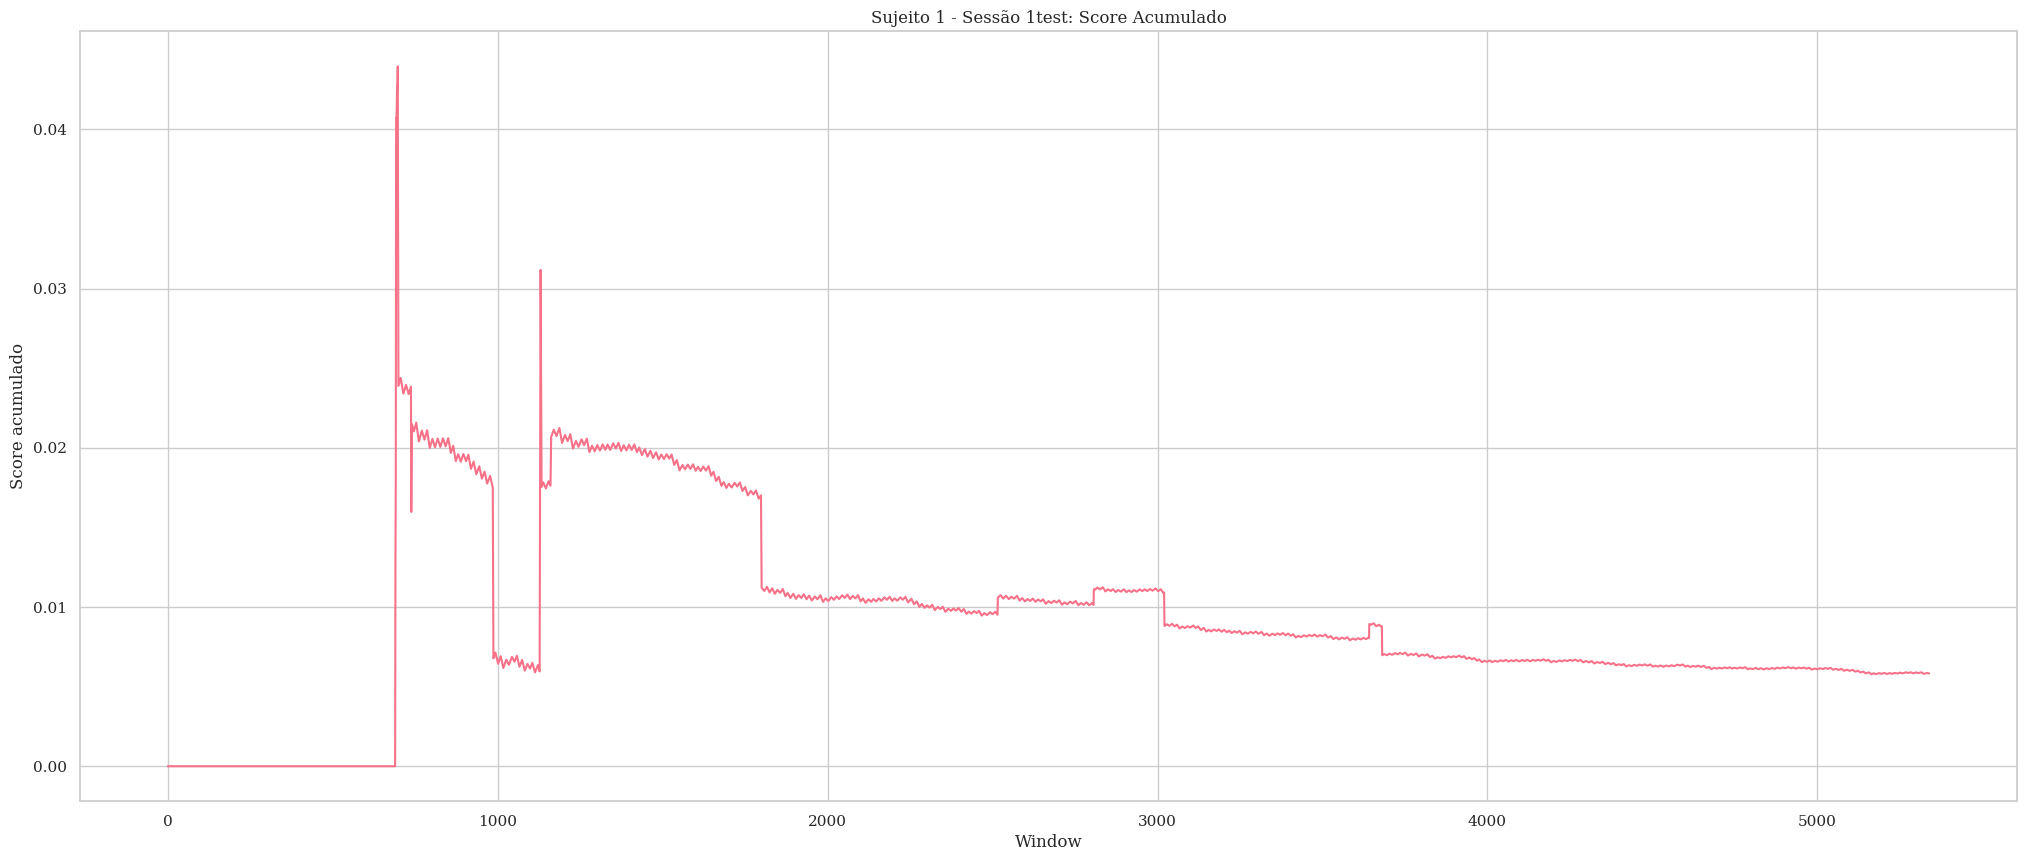

In [ ]:
plot_inter_scores(eval.results_, 1, '1test')